In [277]:
import sys
import torch
import platform
import os

print("Python version:", sys.version)
print("Platform:", platform.platform())
print("Torch version:", torch.__version__)
print("Torch CUDA available:", torch.cuda.is_available())
print("CUDA version (from nvcc):")
!nvcc --version
print("GPU info:")
!nvidia-smi

Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
Platform: Linux-6.1.85+-x86_64-with-glibc2.35
Torch version: 2.6.0+cu124
Torch CUDA available: True
CUDA version (from nvcc):
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
GPU info:
Fri Apr  4 21:05:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|====

In [2]:
!rm -rf /content/flickr8k_dataraw
!unzip -q "/content/drive/MyDrive/ABC/flickr8k.zip" -d /content/flickr8k_dataraw

In [3]:
!mkdir -p /content/flickr8k_local/features
!rm -rf /content/flickr8k_local/features

In [4]:
!cp -r "/content/drive/MyDrive/ABC/flickr8k/flickr8k_captions.json" /content/flickr8k_local/
!unzip -j "/content/drive/MyDrive/ABC/flickr8k_features_top18_tourch.zip" -d /content/flickr8k_local/features

Streaming output truncated to the last 5000 lines.
  inflating: /content/flickr8k_local/features/2328104318_5a43ca170c.npz  
  inflating: /content/flickr8k_local/features/880220939_0ef1c37f1f.npz  
  inflating: /content/flickr8k_local/features/3628103548_2708abcda2.npz  
  inflating: /content/flickr8k_local/features/3259992722_4c5e895734.npz  
  inflating: /content/flickr8k_local/features/1581822598_0ae23074f1.npz  
  inflating: /content/flickr8k_local/features/2659183350_730951f740.npz  
  inflating: /content/flickr8k_local/features/3541915243_956c1aa8ef.npz  
  inflating: /content/flickr8k_local/features/410422753_de506155fa.npz  
  inflating: /content/flickr8k_local/features/1287931016_fb015e2e10.npz  
  inflating: /content/flickr8k_local/features/2930616480_7fd45ca79b.npz  
  inflating: /content/flickr8k_local/features/2333288869_8c01e4c859.npz  
  inflating: /content/flickr8k_local/features/3348191949_b0b925e5f1.npz  
  inflating: /content/flickr8k_local/features/2266144051_614b2d

# Generated Captions


In [124]:
import os
import json
import torch
from tqdm import tqdm
from PIL import Image
from transformers import BlipProcessor, BlipModel
from nltk.tokenize import word_tokenize
import torch.nn.functional as F

@torch.no_grad()
def get_image_feature(img_path, processor, model):
    image = Image.open(img_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to("cuda")
    outputs = model.vision_model(**inputs)
    feat = outputs.last_hidden_state[:, 0, :].squeeze(0)  # CLS token
    return F.normalize(feat, dim=-1)

@torch.no_grad()
def get_text_feature(text, processor, model):
    inputs = processor(text=[text], return_tensors="pt").to("cuda")
    outputs = model.text_model(**inputs)
    feat = outputs.last_hidden_state[:, 0, :].squeeze(0)
    return F.normalize(feat, dim=-1)

def load_caption_dict(captions_json):
    with open(captions_json, 'r') as f:
        data = json.load(f)
    caption_dict = {}
    for item in data:
        caption_dict[item['image_id']] = item['captions']
    return caption_dict

class CaptionRetriever:
    def __init__(self, caption_pool, processor, model):
        self.processor = processor
        self.model = model
        self.caption_pool = list(set(caption_pool))
        print(f"Encoding {len(self.caption_pool)} captions...")
        self.text_feats = []
        for cap in tqdm(self.caption_pool, desc="Encoding captions"):
            feat = get_text_feature(cap, processor, model)
            self.text_feats.append(feat)
        self.text_feats = torch.stack(self.text_feats)  # [N, D]
        self.text_feats = F.normalize(self.text_feats, dim=-1)

    def retrieve(self, image_feat, exclude_list):
        sims = torch.nn.functional.cosine_similarity(image_feat, self.text_feats)
        sorted_idx = torch.argsort(sims, descending=True)
        for idx in sorted_idx:
            cand = self.caption_pool[idx]
            if cand not in exclude_list:
                return cand
        return self.caption_pool[sorted_idx[0]]  # fallback

def generate_semantic_priors(image_dir, caption_json_path, output_json_path):
    print("🔹 Loading captions...")
    caption_dict = load_caption_dict(caption_json_path)
    all_captions = [cap for caps in caption_dict.values() for cap in caps]

    print("🔹 Loading BLIP base model...")
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    model = BlipModel.from_pretrained("Salesforce/blip-image-captioning-base").cuda().eval()

    retriever = CaptionRetriever(all_captions, processor, model)
    semantic_dict = {}

    print("🔹 Retrieving semantic priors...")
    for image_id, gt_caps in tqdm(caption_dict.items()):
        img_path = os.path.join(image_dir, f"{image_id}.jpg")
        if not os.path.exists(img_path):
            continue
        try:
            image_feat = get_image_feature(img_path, processor, model)
            retrieved_caption = retriever.retrieve(image_feat, exclude_list=gt_caps)
            semantic_dict[image_id] = retrieved_caption
        except Exception as e:
            print(f"❌ Error on {image_id}: {e}")

    with open(output_json_path, "w", encoding="utf-8") as f:
        json.dump(semantic_dict, f, indent=2, ensure_ascii=False)
    print(f"✅ Saved semantic priors to {output_json_path}")

In [125]:
!rm /content/flickr8k_local/semantic_priors.json

generate_semantic_priors(
    image_dir="/content/flickr8k_dataraw/Images",
    caption_json_path="/content/flickr8k_local/flickr8k_captions.json",
    output_json_path="/content/flickr8k_local/semantic_priors.json"
)

rm: cannot remove '/content/flickr8k_local/semantic_priors.json': No such file or directory
🔹 Loading captions...
🔹 Loading BLIP base model...


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_mo

Encoding 40201 captions...


Encoding captions: 100%|██████████| 40201/40201 [08:41<00:00, 77.05it/s]


🔹 Retrieving semantic priors...


100%|██████████| 8091/8091 [21:04<00:00,  6.40it/s]


✅ Saved semantic priors to /content/flickr8k_local/semantic_priors.json


# Vocabulary Info

In [275]:
import json
import math
from collections import Counter
from nltk.tokenize import word_tokenize
import nltk
nltk.download("punkt")
nltk.download('punkt_tab')

def build_vocab_from_json(captions_json_path, semantic_json_path=None, min_freq=5):
    from collections import Counter
    from nltk.tokenize import word_tokenize
    import json
    import math

    counter = Counter()

    # Load GT captions
    with open(captions_json_path, "r") as f:
        data = json.load(f)
    for entry in data:
        for caption in entry["captions"]:
            tokens = word_tokenize(caption.lower())
            counter.update(tokens)

    # Load semantic captions nếu có
    if semantic_json_path and os.path.exists(semantic_json_path):
        with open(semantic_json_path, "r") as f:
            semantic_data = json.load(f)
        for caption in semantic_data.values():
            tokens = word_tokenize(caption.lower())
            counter.update(tokens)

    # Tạo vocab
    special_tokens = ['<pad>', '<bos>', '<eos>', '<unk>']
    sorted_vocab = sorted([(w, f) for w, f in counter.items() if f >= min_freq], key=lambda x: -x[1])
    vocab = special_tokens + [w for w, _ in sorted_vocab]

    word2idx = {w: i for i, w in enumerate(vocab)}
    idx2word = {i: w for w, i in word2idx.items()}
    bit_length = math.ceil(math.log2(len(word2idx)))

    print(f"Vocab size: {len(word2idx)} (after including semantic)")
    print(f"Bit length: {bit_length}")
    return word2idx, idx2word, bit_length

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [276]:
word2idx, idx2word, bit_length = build_vocab_from_json(
    captions_json_path="/content/flickr8k_local/flickr8k_captions.json",
    semantic_json_path="/content/flickr8k_local/semantic_priors.json",
    min_freq=5
)

Vocab size: 3053 (after including semantic)
Bit length: 12


In [274]:
print("word2idx sample:", dict(list(word2idx.items())[:10]))
print("idx2word sample:", {k: idx2word[k] for k in range(10)})
print("bit_length:", bit_length)

word2idx sample: {'<pad>': 0, '<bos>': 1, '<eos>': 2, '<unk>': 3, 'a': 4, '.': 5, 'in': 6, 'the': 7, 'on': 8, 'is': 9}
idx2word sample: {0: '<pad>', 1: '<bos>', 2: '<eos>', 3: '<unk>', 4: 'a', 5: '.', 6: 'in', 7: 'the', 8: 'on', 9: 'is'}
bit_length: 12


# Dataset Split


In [160]:
import json
import random

def create_splits_from_captions(caption_path, seed=42, train_ratio=0.8, val_ratio=0.1):
    with open(caption_path, "r") as f:
        captions = json.load(f)

    # Lấy unique image_id
    image_ids = sorted(set(entry["image_id"] for entry in captions))

    # Shuffle
    random.seed(seed)
    random.shuffle(image_ids)

    # Split
    n = len(image_ids)
    n_train = int(train_ratio * n)
    n_val = int(val_ratio * n)
    n_test = n - n_train - n_val

    splits = {
        "train": image_ids[:n_train],
        "val": image_ids[n_train:n_train + n_val],
        "test": image_ids[n_train + n_val:]
    }

    print(f"✅ Total: {n} → Train: {len(splits['train'])}, Val: {len(splits['val'])}, Test: {len(splits['test'])}")
    return splits

In [161]:
splits = create_splits_from_captions("/content/flickr8k_local/flickr8k_captions.json")

with open("/content/flickr8k_local/flickr8k_splits.json", "w") as f:
    json.dump(splits, f, indent=2)

✅ Total: 8091 → Train: 6472, Val: 809, Test: 810


In [163]:
def flatten_split(data, split_ids):
    flattened = []
    for entry in data:
        if entry["image_id"] in split_ids:
            for caption in entry["captions"]:
                flattened.append((entry["image_id"], caption))
    return flattened

with open("/content/flickr8k_local/flickr8k_captions.json") as f:
    data = json.load(f)

with open("/content/flickr8k_local/flickr8k_splits.json") as f:
    splits = json.load(f)

train_data = flatten_split(data, splits["train"])
val_data = flatten_split(data, splits["val"])
test_data = flatten_split(data, splits["test"])
print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

Train: 32360, Val: 4045, Test: 4050


# Flickr8kDatasetV2

In [164]:
import os
import json
import torch
import numpy as np
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset

In [165]:
import os
import json
import torch
import numpy as np
from torch.utils.data import Dataset
from nltk.tokenize import word_tokenize

class Flickr8kDatasetV2(Dataset):
    def __init__(self, flattened_list, features_dir, word2idx, bit_length=14, mode='bit',
                 semantic_json_path=None):
        self.samples = flattened_list
        self.features_dir = features_dir
        self.word2idx = word2idx
        self.bit_length = bit_length
        self.mode = mode

        # Load semantic priors nếu có
        if semantic_json_path and os.path.exists(semantic_json_path):
            with open(semantic_json_path, 'r') as f:
                self.semantic_dict = json.load(f)
        else:
            self.semantic_dict = {}

    def tokenize(self, text, max_len=25):
        tokens = word_tokenize(text.lower().strip())
        tokens = ['<bos>'] + tokens[:max_len - 2] + ['<eos>']
        return tokens

    def caption_to_bits(self, tokens):
        bits = []
        for word in tokens:
            idx = self.word2idx.get(word, self.word2idx["<unk>"])
            bin_str = bin(idx)[2:].zfill(self.bit_length)
            bits.append([int(b) for b in bin_str])
        return torch.tensor(bits, dtype=torch.float32)

    def caption_to_indices(self, tokens):
        return torch.tensor(
            [self.word2idx.get(tok, self.word2idx["<unk>"]) for tok in tokens],
            dtype=torch.long
        )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_id, caption = self.samples[idx]
        npz_path = os.path.join(self.features_dir, f"{image_id}.npz")
        data = np.load(npz_path)

        visual_feats = torch.tensor(data["features"], dtype=torch.float32)
        boxes = torch.tensor(data["boxes"], dtype=torch.float32)
        box_mask = (boxes.sum(dim=1) == 0)

        tokens = self.tokenize(caption)
        if self.mode == 'bit':
            x0 = self.caption_to_bits(tokens)
        else:
            x0 = self.caption_to_indices(tokens)

        # ➕ semantic caption nếu có
        if image_id in self.semantic_dict:
            sem_caption = self.semantic_dict[image_id]
            sem_tokens = self.tokenize(sem_caption)
            semantic_idx = self.caption_to_indices(sem_tokens)
        else:
            semantic_idx = torch.zeros(1, dtype=torch.long)  # fallback nếu thiếu

        caption_idx = self.caption_to_indices(tokens)

        return x0, visual_feats, box_mask, len(tokens), semantic_idx, caption_idx


In [166]:
from torch.nn.utils.rnn import pad_sequence
import torch

def collate_fn_cascade(batch, max_len=25):
    x0_list, visual_list, box_mask_list, cap_lengths, semantic_list, caption_idx_list = zip(*batch)

    # Pad x0 (bit vector)
    x0 = pad_sequence(x0_list, batch_first=True, padding_value=0.0)
    B, T, D = x0.shape
    if T < max_len:
        pad = torch.zeros((B, max_len - T, D), dtype=x0.dtype)
        x0 = torch.cat([x0, pad], dim=1)
    else:
        x0 = x0[:, :max_len, :]

    # Pad visual features
    visual_feats = pad_sequence(visual_list, batch_first=True, padding_value=0.0)
    box_mask = pad_sequence(box_mask_list, batch_first=True, padding_value=1).bool()
    lengths = torch.tensor([min(l, max_len) for l in cap_lengths], dtype=torch.long)

    # Pad semantic index
    semantic_idx = pad_sequence(semantic_list, batch_first=True, padding_value=0)
    if semantic_idx.size(1) < max_len:
        pad = torch.zeros((B, max_len - semantic_idx.size(1)), dtype=torch.long)
        semantic_idx = torch.cat([semantic_idx, pad], dim=1)
    else:
        semantic_idx = semantic_idx[:, :max_len]

    # Pad caption index (GT caption)
    caption_idx = pad_sequence(caption_idx_list, batch_first=True, padding_value=0)
    if caption_idx.size(1) < max_len:
        pad = torch.zeros((B, max_len - caption_idx.size(1)), dtype=torch.long)
        caption_idx = torch.cat([caption_idx, pad], dim=1)
    else:
        caption_idx = caption_idx[:, :max_len]

    return x0, visual_feats, box_mask, lengths, semantic_idx, caption_idx

In [265]:
# Dataset
train_dataset = Flickr8kDatasetV2(
    flattened_list=train_data,
    features_dir="/content/flickr8k_local/features",
    word2idx=word2idx,
    bit_length=bit_length,
    mode='bit',  # hoặc 'index'
    semantic_json_path="/content/flickr8k_local/semantic_priors.json"
)

val_dataset = Flickr8kDatasetV2(
    flattened_list=val_data,
    features_dir="/content/flickr8k_local/features",
    word2idx=word2idx,
    bit_length=bit_length,
    mode='bit',
    semantic_json_path="/content/flickr8k_local/semantic_priors.json"
)


test_dataset = Flickr8kDatasetV2(
    flattened_list=test_data,
    features_dir="/content/flickr8k_local/features",
    word2idx=word2idx,
    bit_length=bit_length,
    mode='bit',
    semantic_json_path="/content/flickr8k_local/semantic_priors.json"
)

In [266]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=collate_fn_cascade
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    collate_fn=collate_fn_cascade
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    collate_fn=collate_fn_cascade
)

In [310]:
from pprint import pprint

def decode_bits_to_words(bit_tensor, idx2word):
    """
    bit_tensor: [T, bit_length] (float or int)
    """
    words = []
    for bit_vec in bit_tensor:
        bit_vec = (bit_vec > 0.5).int()  # round về 0/1 nếu là float
        bit_str = ''.join(str(b.item()) for b in bit_vec)
        idx = int(bit_str, 2)
        word = idx2word.get(idx, "<unk>")
        if word == "<eos>":
            break
        if word not in ("<bos>", "<pad>"):
            words.append(word)
    return words

def debug_batch_input(dataset, batch_size=64, max_len=25):
    from torch.utils.data import DataLoader

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn_cascade
    )

    x0, visual_feats, box_mask, lengths, semantic_idx, caption_idx = next(iter(loader))

    print(f"x0.shape        : {x0.shape}")  # [B, T, bit] or [B, T]
    print(f"visual_feats    : {visual_feats.shape}")  # [B, S, 1024]
    print(f"box_mask        : {box_mask.shape}")
    print(f"box_mask[0]     : {box_mask[0].tolist()}")
    print(f"lengths         : {lengths.tolist()}")
    print(f"semantic_idx    : {semantic_idx.shape}")
    print(f"semantic_idx[0] : {semantic_idx[0].tolist()}")
    print(f"caption_idx[0]  : {caption_idx[0].tolist()}")



    decoded_words = decode_bits_to_words(x0[0][:lengths[0]], idx2word)
    gt_words = [idx2word.get(i.item(), "<unk>") for i in caption_idx[0][:lengths[0]] if i.item() not in [0, 1, 2]]
    print("Decoded caption from x0 (bit):")
    pprint(decoded_words)
    print("Ground-truth caption:")
    pprint(gt_words)

debug_batch_input(train_dataset, batch_size=64, max_len=25)

x0.shape        : torch.Size([64, 25, 12])
visual_feats    : torch.Size([64, 18, 1024])
box_mask        : torch.Size([64, 18])
box_mask[0]     : [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
lengths         : [14, 20, 25, 11, 11, 10, 16, 9, 12, 10, 10, 12, 25, 14, 17, 10, 16, 11, 9, 24, 17, 14, 15, 13, 11, 17, 20, 9, 7, 12, 12, 9, 15, 19, 15, 16, 14, 17, 16, 10, 13, 10, 11, 19, 9, 9, 15, 17, 17, 12, 12, 12, 14, 9, 16, 11, 12, 13, 16, 18, 15, 14, 14, 17]
semantic_idx    : torch.Size([64, 25])
semantic_idx[0] : [1, 4, 262, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
caption_idx[0]  : [1, 1833, 20, 152, 453, 8, 4, 896, 102, 24, 1079, 583, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded caption from x0 (bit):
['skateboarders',
 'are',
 'doing',
 'tricks',
 'on',
 'a',
 'staircase',
 'next',
 'to',
 'mirror',
 'buildings',
 '.']
Ground-truth caption:
['skateboarders',
 'are',
 'doing',
 'tr

# DiffusionTransformerBlock

In [231]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiffusionTransformerBlock(nn.Module):
    def __init__(self, *,
                 vocab_size,
                 bit_length,
                 hidden_dim=512,
                 visual_dim=1024,
                 embed_dim=256,
                 nhead=8,
                 dropout=0.1,
                 visual_layers=2,
                 semantic_layers=2,
                 decoder_layers=2):
        super().__init__()

        self.bit_length = bit_length
        self.vocab_size = vocab_size

        # Visual Encoder
        self.visual_proj = nn.Linear(visual_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, dropout=dropout, batch_first=True)
        self.visual_encoder = nn.TransformerEncoder(encoder_layer, num_layers=visual_layers)
        self.visual_norm = nn.LayerNorm(hidden_dim)

        # Semantic Encoder
        self.semantic_embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.semantic_proj = nn.Linear(embed_dim, hidden_dim)
        semantic_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, dropout=dropout, batch_first=True)
        self.semantic_encoder = nn.TransformerEncoder(semantic_layer, num_layers=semantic_layers)
        self.semantic_norm = nn.LayerNorm(hidden_dim)

        # Decoder (Sentence Generator)
        self.decoder_embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.decoder_input_proj = nn.Linear(embed_dim, hidden_dim)
        decoder_layer = nn.TransformerDecoderLayer(d_model=hidden_dim, nhead=nhead, dropout=dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=decoder_layers)
        self.decoder_norm = nn.LayerNorm(hidden_dim)
        self.output_proj = nn.Linear(hidden_dim, vocab_size)

        # Bit vector projection
        self.bit_input_proj = nn.Linear(bit_length, hidden_dim)
        self.bit_output_proj = nn.Linear(hidden_dim, bit_length)

        # Bit embedding projection to vocab
        bit_table = [list(map(int, bin(i)[2:].zfill(bit_length))) for i in range(vocab_size)]
        self.bit_matrix = torch.tensor(bit_table, dtype=torch.float32)  # [V, bit]

    def forward(self, x_t, visual_feats, box_mask, semantic_idx, caption_idx, lengths):
        """
        Args:
            x_t: [B, T, bit_length]
            visual_feats: [B, S, visual_dim]
            box_mask: [B, S]
            semantic_idx: [B, T_sem] (retrieved caption)
            caption_idx: [B, T] (GT caption index)
            lengths: [B]
        Returns:
            logits: [B, T, vocab_size]
            x0_pred: [B, T, bit_length]
        """
        device = x_t.device

        # ---- Visual Encoder ----
        v = self.visual_proj(visual_feats)
        v_enc = self.visual_encoder(v, src_key_padding_mask=box_mask)
        v_enc = self.visual_norm(v_enc)
        v_cond = v_enc.masked_fill(box_mask.unsqueeze(-1), 0.0).sum(dim=1) / (~box_mask).sum(dim=1, keepdim=True).clamp(min=1)

        # ---- Semantic Encoder ----
        sem_embed = self.semantic_embedding(semantic_idx)
        sem_proj = self.semantic_proj(sem_embed)
        sem_enc = self.semantic_encoder(sem_proj, src_key_padding_mask=(semantic_idx == 0))
        sem_enc = self.semantic_norm(sem_enc)
        sem_cond = sem_enc.masked_fill((semantic_idx == 0).unsqueeze(-1), 0.0).sum(dim=1) / (semantic_idx != 0).sum(dim=1, keepdim=True).clamp(min=1)

        # ---- Denoising x_t → x0_pred ----
        x_embed = self.bit_input_proj(x_t)
        mem = v_cond + sem_cond
        mem = mem.unsqueeze(1)  # [B, 1, H]
        pad_mask = (x_t.abs().sum(dim=-1) == 0)
        out = self.decoder(x_embed, mem, tgt_key_padding_mask=pad_mask)
        x0_pred = self.bit_output_proj(out)  # [B, T, bit_length]

        # ---- Bit to vocab logits ----
        x0_idx = x0_pred.detach()
        sim = F.cosine_similarity(x0_idx.view(-1, self.bit_length).unsqueeze(1), self.bit_matrix.to(device).unsqueeze(0), dim=-1)
        bit_logits = sim.view(x_t.size(0), x_t.size(1), self.vocab_size)

        # ---- Sentence Decoder ----
        tgt_embed = self.decoder_embedding(caption_idx)
        tgt_proj = self.decoder_input_proj(tgt_embed)
        causal_mask = torch.triu(torch.ones((caption_idx.size(1), caption_idx.size(1)), device=device), diagonal=1).bool()
        caption_logits = self.output_proj(
            self.decoder(tgt_proj, mem, tgt_mask=causal_mask, tgt_key_padding_mask=(caption_idx == 0))
        )

        return caption_logits, x0_pred


In [232]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CascadedDiffusionTransformer(nn.Module):
    def __init__(self, num_blocks, block_args):
        super().__init__()
        self.blocks = nn.ModuleList([
            DiffusionTransformerBlock(**block_args)
            for _ in range(num_blocks)
        ])
        self.block_weights = nn.Parameter(torch.ones(num_blocks) / num_blocks)

    def forward(self, x_t, visual_feats, box_mask, semantic_idx, caption_idx, lengths):
        logits_list = []
        x0_pred_list = []

        for block in self.blocks:
            logits, x0_pred = block(x_t, visual_feats, box_mask, semantic_idx, caption_idx, lengths)
            logits_list.append(logits)
            x0_pred_list.append(x0_pred)
            x_t = x0_pred  # cascade: output làm input cho block kế tiếp

        weights = F.softmax(self.block_weights, dim=0)
        final_logits = sum(w * o for w, o in zip(weights, logits_list))
        final_x0_pred = sum(w * o for w, o in zip(weights, x0_pred_list))

        return final_logits, final_x0_pred

# Train step

In [281]:
import torch

def add_noise(x0, t, alpha=5.0):
    """
    Args:
        x0: [B, T, bit_length] – input caption bit vector
        t:  [B, 1, 1] – time step noise (uniform [0,1])
    Returns:
        x_t: noisy version of x0
        eps: added Gaussian noise
    """
    gamma = alpha * (1 - torch.cos(t * torch.pi / 2))  # cosine noise schedule
    noise = torch.randn_like(x0)

    coef_x0 = torch.sqrt(torch.sigmoid(-gamma))
    coef_eps = torch.sqrt(1.0 - coef_x0 ** 2)

    x_t = coef_x0 * x0 + coef_eps * noise
    return x_t, noise


In [233]:
# def add_noise(x0, t, alpha=5.0):
#     """
#     No noise version — identity
#     """
#     noise = torch.zeros_like(x0)
#     return x0.clone(), noise

In [282]:
def train_step_cascade(model, batch, optimizer, device, alpha=0.5, scaler=None):
    x0, visual_feats, box_mask, lengths, semantic_idx, caption_idx = batch
    x0 = x0.to(device)
    visual_feats = visual_feats.to(device)
    box_mask = box_mask.to(device)
    lengths = lengths.to(device)
    semantic_idx = semantic_idx.to(device)
    caption_idx = caption_idx.to(device)

    t = torch.rand(x0.size(0), 1, 1).to(device)
    x_t, _ = add_noise(x0, t)  # bạn có thể dùng hàm add_noise bạn đã viết

    if scaler is not None:
        with torch.cuda.amp.autocast():
            logits, x0_pred = model(x_t, visual_feats, box_mask, semantic_idx, caption_idx, lengths)

            # lbit = ((x0_pred - x0)**2).masked_fill(pad_mask.unsqueeze(-1), 0.0).sum() / ((~pad_mask).sum() * x0.size(-1))

            pad_mask = torch.arange(x0.size(1), device=device).unsqueeze(0) >= lengths.unsqueeze(1)
            lbit = ((x0_pred - x0)**2).masked_fill(pad_mask.unsqueeze(-1), 0.0).sum() / ((~pad_mask).sum() * x0.size(-1))
            # --- Cross Entropy Loss for caption (Stage 2) ---
            logits_flat = logits.view(-1, logits.size(-1))
            target = caption_idx.view(-1)
            lxe = F.cross_entropy(logits_flat, target, ignore_index=0)
            # --- Final weighted loss ---
            loss = alpha * lbit + (1 - alpha) * lxe

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    else:
        logits, x0_pred = model(x_t, visual_feats, box_mask, semantic_idx, caption_idx, lengths)

        # lbit = ((x0_pred - x0)**2).masked_fill(pad_mask.unsqueeze(-1), 0.0).sum() / ((~pad_mask).sum() * x0.size(-1))

        pad_mask = torch.arange(x0.size(1), device=device).unsqueeze(0) >= lengths.unsqueeze(1)
        lbit = ((x0_pred - x0)**2).masked_fill(pad_mask.unsqueeze(-1), 0.0).sum() / ((~pad_mask).sum() * x0.size(-1))
        # --- Cross Entropy Loss for caption (Stage 2) ---
        logits_flat = logits.view(-1, logits.size(-1))
        target = caption_idx.view(-1)
        lxe = F.cross_entropy(logits_flat, target, ignore_index=0)
        # --- Final weighted loss ---
        loss = alpha * lbit + (1 - alpha) * lxe

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item(), lbit.item(), lxe.item()

In [283]:
@torch.no_grad()
def evaluate_step_cascade(model, batch, device, alpha=0.5):
    x0, visual_feats, box_mask, lengths, semantic_idx, caption_idx = batch
    x0 = x0.to(device)
    visual_feats = visual_feats.to(device)
    box_mask = box_mask.to(device)
    lengths = lengths.to(device)
    semantic_idx = semantic_idx.to(device)
    caption_idx = caption_idx.to(device)

    t = torch.rand(x0.size(0), 1, 1).to(device)
    x_t, _ = add_noise(x0, t)  # xₜ ← noise from x₀

    logits, x0_pred = model(x_t, visual_feats, box_mask, semantic_idx, caption_idx, lengths)

   # lbit = ((x0_pred - x0)**2).masked_fill(pad_mask.unsqueeze(-1), 0.0).sum() / ((~pad_mask).sum() * x0.size(-1))

    pad_mask = torch.arange(x0.size(1), device=device).unsqueeze(0) >= lengths.unsqueeze(1)
    # → Lbit: trung bình theo tất cả các bit không bị pad
    lbit = ((x0_pred - x0)**2).masked_fill(pad_mask.unsqueeze(-1), 0.0).sum() / ((~pad_mask).sum() * x0.size(-1))
    # --- Cross Entropy Loss for caption (Stage 2) ---
    logits_flat = logits.view(-1, logits.size(-1))
    target = caption_idx.view(-1)
    lxe = F.cross_entropy(logits_flat, target, ignore_index=0)
    # --- Final weighted loss ---
    loss = alpha * lbit + (1 - alpha) * lxe

    return loss.item(), lbit.item(), lxe.item()

In [284]:
import torch
from tqdm import tqdm

def train_model_cascade(model, train_loader, val_loader, optimizer, device,
                        epochs=10, alpha=0.5, scaler=None):
    best_val_loss = float('inf')
    logs = {"train_loss": [], "val_loss": [], "lbit": [], "lxe": []}

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss, train_lbit, train_lxe = 0.0, 0.0, 0.0

        pbar = tqdm(train_loader, desc=f"[Train] Epoch {epoch}", leave=False)
        for batch in pbar:
            loss, lbit, lxe = train_step_cascade(model, batch, optimizer, device, alpha=alpha, scaler=scaler)
            train_loss += loss
            train_lbit += lbit
            train_lxe += lxe
            pbar.set_postfix({"loss": loss, "lbit": lbit, "lxe": lxe})

        n_batches = len(train_loader)
        logs["train_loss"].append(train_loss / n_batches)
        logs["lbit"].append(train_lbit / n_batches)
        logs["lxe"].append(train_lxe / n_batches)

        # Eval
        model.eval()
        val_loss, val_lbit, val_lxe = 0.0, 0.0, 0.0
        for batch in val_loader:
            loss, lbit, lxe = evaluate_step_cascade(model, batch, device, alpha=alpha)
            val_loss += loss
            val_lbit += lbit
            val_lxe += lxe

        val_loss /= len(val_loader)
        logs["val_loss"].append(val_loss)

        print(f"\nEpoch {epoch:02d} | Train Loss: {logs['train_loss'][-1]:.4f} | Lbit: {train_lbit / n_batches:.4f} | LXE: {train_lxe / n_batches:.4f}")
        print(f"Val Loss : {val_loss:.4f} | Lbit: {val_lbit / len(val_loader):.4f} | LXE: {val_lxe / len(val_loader):.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model_cascade.pt")
            print(f"Saved best model at epoch {epoch}")

    return logs

In [311]:
block_args = {
    "vocab_size": len(word2idx),
    "bit_length": 12,
    "hidden_dim": 512,
    "visual_dim": 1024,
    "embed_dim": 256,
    "nhead": 8,
    "dropout": 0.1,
    "visual_layers": 2,
    "semantic_layers": 2,
    "decoder_layers": 2,
}

model = CascadedDiffusionTransformer(
    num_blocks=3,
    block_args=block_args
).to("cuda")

print(block_args)

{'vocab_size': 3053, 'bit_length': 12, 'hidden_dim': 512, 'visual_dim': 1024, 'embed_dim': 256, 'nhead': 8, 'dropout': 0.1, 'visual_layers': 2, 'semantic_layers': 2, 'decoder_layers': 2}


In [312]:
print(model)

CascadedDiffusionTransformer(
  (blocks): ModuleList(
    (0-2): 3 x DiffusionTransformerBlock(
      (visual_proj): Linear(in_features=1024, out_features=512, bias=True)
      (visual_encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-1): 2 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
            )
            (linear1): Linear(in_features=512, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2048, out_features=512, bias=True)
            (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (visual_norm): LayerNorm((512,), eps=1e-05, e

In [358]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-4,
    weight_decay=1e-2,
    betas=(0.9, 0.999),
    eps=1e-8
)

logs = train_model_cascade(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device="cuda",
    epochs=15,
    alpha=0.5
)

Epoch 01 | Train Loss: 2.5855 | Lbit: 0.6746 | LXE: 1.9062
Val Loss : 2.5839 | Lbit: 0.6762 | LXE: 1.9077
Saved best model at epoch 1
Epoch 02 | Train Loss: 0.8633 | Lbit: 0.6037 | LXE: 0.2555
Val Loss : 0.8671 | Lbit: 0.6069 | LXE: 0.2603
Saved best model at epoch 2
Epoch 03 | Train Loss: 0.6892 | Lbit: 0.5406 | LXE: 0.1442
Val Loss : 0.6885 | Lbit: 0.5433 | LXE: 0.1452
Saved best model at epoch 3
Epoch 04 | Train Loss: 0.5698 | Lbit: 0.4837 | LXE: 0.0837
Val Loss : 0.5733 | Lbit: 0.4862 | LXE: 0.0872
Saved best model at epoch 4
Epoch 05 | Train Loss: 0.4451 | Lbit: 0.4358 | LXE: 0.0080
Val Loss : 0.4506 | Lbit: 0.4396 | LXE: 0.0109
Saved best model at epoch 5
Epoch 06 | Train Loss: 0.4055 | Lbit: 0.3926 | LXE: 0.0082
Val Loss : 0.4046 | Lbit: 0.3964 | LXE: 0.0082
Saved best model at epoch 6
Epoch 07 | Train Loss: 0.3588 | Lbit: 0.3505 | LXE: 0.0058
Val Loss : 0.3575 | Lbit: 0.3510 | LXE: 0.0065
Saved best model at epoch 7
Epoch 08 | Train Loss: 0.3229 | Lbit: 0.3112 | LXE: 0.0075
Val

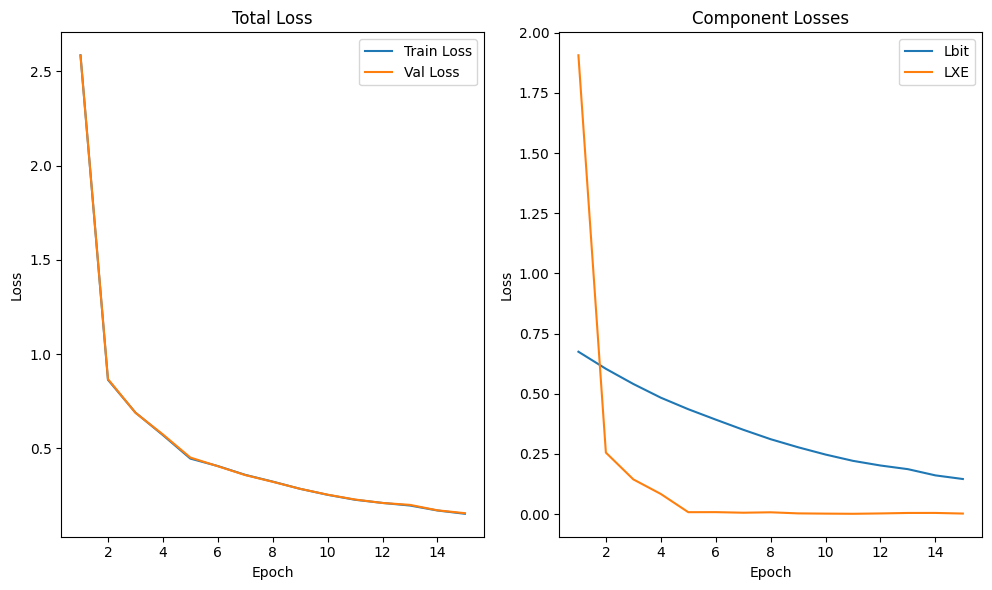

In [359]:
import matplotlib.pyplot as plt

def plot_training_logs(logs):
    epochs = range(1, len(logs["train_loss"]) + 1)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, logs["train_loss"], label="Train Loss")
    plt.plot(epochs, logs["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Total Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    if "lbit" in logs and "lxe" in logs:
        plt.plot(epochs, logs["lbit"], label="Lbit")
        plt.plot(epochs, logs["lxe"], label="LXE")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Component Losses")
        plt.legend()

    if "lr" in logs and logs["lr"]:
        plt.subplot(1, 3, 3)
        plt.plot(logs["lr"], label="Learning Rate")
        plt.xlabel("Step")
        plt.ylabel("LR")
        plt.title("Learning Rate Schedule")
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_logs(logs)

# Eval Samples

In [246]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F


def visualize_caption_result(image_id, caption_gen, gt_captions, feature_dir, image_dir):
    image_path = os.path.join(image_dir, f"{image_id}.jpg")
    image = Image.open(image_path).convert("RGB")

    npz_path = os.path.join(feature_dir, f"{image_id}.npz")
    data = np.load(npz_path)
    boxes = data['boxes']

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image)

    for box in boxes:
        if not np.any(box):
            continue
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=1.5, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)

    ax.set_title(f"ID: {image_id}.jpg\nGenerated: {caption_gen}", fontsize=10)
    ax.axis("off")

    print(f"\nImage ID: {image_id}.jpg")
    print("Generated caption:\n   " + caption_gen)
    print("Ground-truth captions:")
    for i, cap in enumerate(gt_captions):
        print(f"   {i+1}. {cap}")

    plt.tight_layout()
    plt.show()


def decode_caption_from_logits(logits, idx2word):
    idx = logits.argmax(dim=-1).tolist()  # [T]
    words = []
    for i in idx:
        word = idx2word.get(i, "<unk>")
        if word == "<eos>":
            break
        if word not in ("<pad>", "<bos>"):
            words.append(word)
    return ' '.join(words)


def decode_caption_from_indices(indices, idx2word):
    words = []
    for i in indices.tolist():
        word = idx2word.get(i, "<unk>")
        if word == "<eos>":
            break
        if word not in ("<pad>", "<bos>"):
            words.append(word)
    return ' '.join(words)


def generate_caption(model, visual_feats, box_mask, semantic_idx, idx2word, max_len=25, beam_size=3):
    model.eval()
    device = visual_feats.device

    with torch.no_grad():
        v = model.blocks[0].visual_proj(visual_feats)
        v_enc = model.blocks[0].visual_encoder(v, src_key_padding_mask=box_mask)
        v_enc = model.blocks[0].visual_norm(v_enc)
        v_cond = v_enc.masked_fill(box_mask.unsqueeze(-1), 0.0).sum(dim=1) / (~box_mask).sum(dim=1, keepdim=True).clamp(min=1)

        sem_embed = model.blocks[0].semantic_embedding(semantic_idx)
        sem_proj = model.blocks[0].semantic_proj(sem_embed)
        sem_enc = model.blocks[0].semantic_encoder(sem_proj, src_key_padding_mask=(semantic_idx == 0))
        sem_enc = model.blocks[0].semantic_norm(sem_enc)
        sem_cond = sem_enc.masked_fill((semantic_idx == 0).unsqueeze(-1), 0.0).sum(dim=1) / (semantic_idx != 0).sum(dim=1, keepdim=True).clamp(min=1)

        context = v_cond + sem_cond
        memory = context.unsqueeze(1)

        beams = [([1], 0.0)]

        for t in range(max_len):
            new_beams = []
            for seq, score in beams:
                if seq[-1] == 2:
                    new_beams.append((seq, score))
                    continue

                tgt = torch.tensor(seq, dtype=torch.long, device=device).unsqueeze(0)
                tgt_embed = model.blocks[0].decoder_embedding(tgt)
                tgt_proj = model.blocks[0].decoder_input_proj(tgt_embed)

                causal_mask = torch.triu(torch.ones((tgt.size(1), tgt.size(1)), device=device), diagonal=1).bool()
                out = model.blocks[0].decoder(tgt_proj, memory, tgt_mask=causal_mask, tgt_key_padding_mask=(tgt == 0))
                logits = model.blocks[0].output_proj(out)[:, -1, :]
                log_probs = F.log_softmax(logits, dim=-1).squeeze(0)

                if t > 0:
                    log_probs[1] = -1e9

                topk_log_probs, topk_indices = torch.topk(log_probs, beam_size)
                for i in range(beam_size):
                    new_seq = seq + [topk_indices[i].item()]
                    new_score = score + topk_log_probs[i].item()
                    new_beams.append((new_seq, new_score))

            beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_size]

            if all(seq[-1] == 2 for seq, _ in beams):
                break

        best_seq = beams[0][0][1:]
        words = []
        for idx in best_seq:
            word = idx2word.get(idx, '<unk>')
            if word == '<eos>':
                break
            if word not in ('<pad>', '<bos>'):
                words.append(word)
        return ' '.join(words)


def test_one_sample(model, dataset, idx2word, index, feature_dir, image_dir, max_len=25):
    sample_dataset = torch.utils.data.Subset(dataset, [index])
    test_loader = DataLoader(sample_dataset, batch_size=1, shuffle=False,
                             collate_fn=lambda batch: collate_fn_cascade(batch, max_len=max_len))

    batch = next(iter(test_loader))
    x0, visual_feats, box_mask, lengths, semantic_idx, caption_idx = batch

    x0 = x0.to("cuda")
    visual_feats = visual_feats.to("cuda")
    box_mask = box_mask.to("cuda")
    lengths = lengths.to("cuda")
    semantic_idx = semantic_idx.to("cuda")
    caption_idx = caption_idx.to("cuda")

    caption = generate_caption(
        model=model,
        visual_feats=visual_feats[0:1],
        box_mask=box_mask[0:1],
        semantic_idx=semantic_idx[0:1],
        idx2word=idx2word,
        max_len=25,
        beam_size=5
    )

    sem_caption = decode_caption_from_indices(semantic_idx[0], idx2word)
    image_id, gt_caption = dataset.samples[index]

    print("Semantic caption:", sem_caption)
    print("Ground-truth    :", gt_caption)

    visualize_caption_result(
        image_id=image_id,
        caption_gen=caption,
        gt_captions=[gt_caption],
        feature_dir=feature_dir,
        image_dir=image_dir
    )


In [324]:
test_dataset = Flickr8kDatasetV2(
    flattened_list=test_data,
    features_dir="/content/flickr8k_local/features",
    word2idx=word2idx,
    bit_length=bit_length,
    mode='bit',  # hoặc 'index'
    semantic_json_path="/content/flickr8k_local/semantic_priors.json"
)

Semantic caption: a man practicing boxing
Ground-truth    : A couple of people are riding ATV 's on a dirt track .

Image ID: 3458215674_2aa5e64643.jpg
Generated caption:
   people on atv vehicles are competing against each other .
Ground-truth captions:
   1. A couple of people are riding ATV 's on a dirt track .


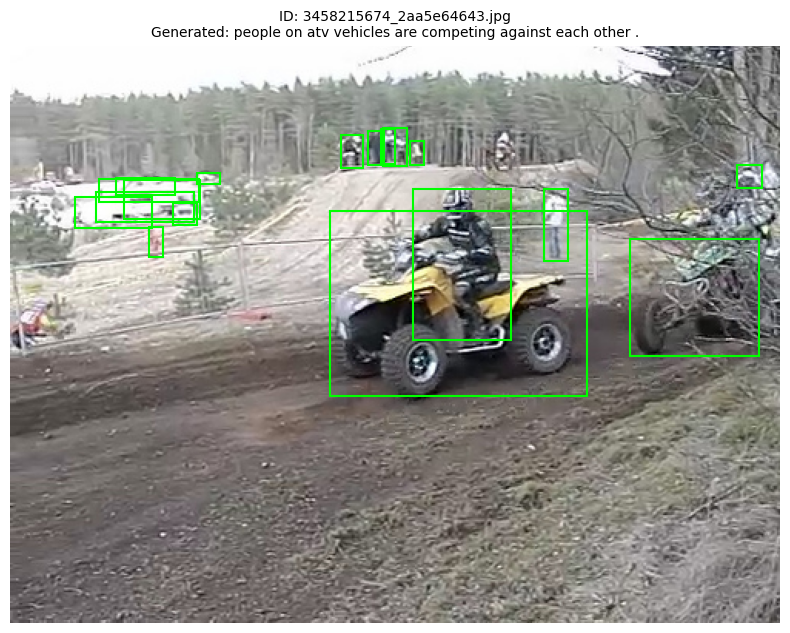

In [345]:
test_one_sample(
    model=model,
    dataset=test_dataset,
    idx2word=idx2word,
    index=2910,
    feature_dir="/content/flickr8k_local/features",
    image_dir="/content/flickr8k_dataraw/Images"
)

Semantic caption: a white puppy holds a yellow tennis ball in its mouth .
Ground-truth    : A black and white dog is in the grass with a red striped disk .

Image ID: 2444821454_22a346c996.jpg
Generated caption:
   a black and white dog jumping in the grass after a frisbee .
Ground-truth captions:
   1. A black and white dog is in the grass with a red striped disk .


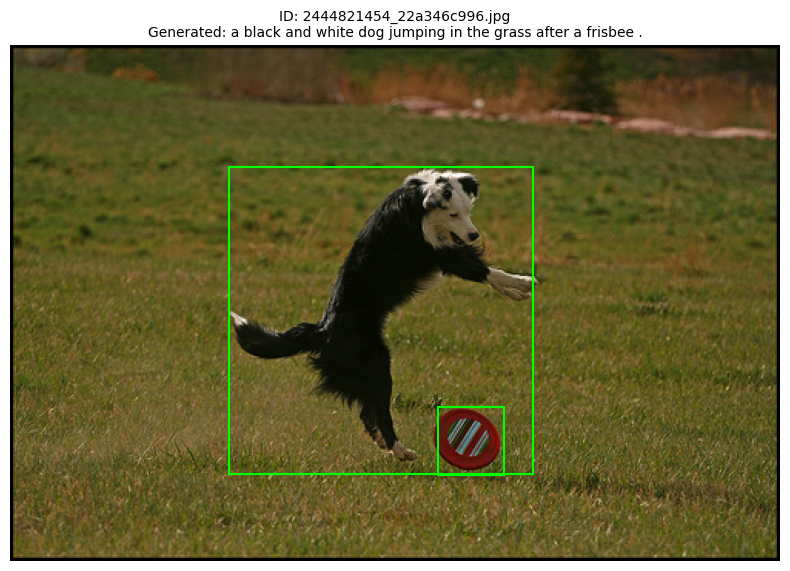

In [333]:
test_one_sample(
    model=model,
    dataset=test_dataset,
    idx2word=idx2word,
    index=1005,
    feature_dir="/content/flickr8k_local/features",
    image_dir="/content/flickr8k_dataraw/Images"
)

Semantic caption: a rafter in a yellow raft in a steamy white river .
Ground-truth    : A young boy climbing in a playhouse

Image ID: 2407091303_931c918490.jpg
Generated caption:
   a child plays at a playground .
Ground-truth captions:
   1. A young boy climbing in a playhouse


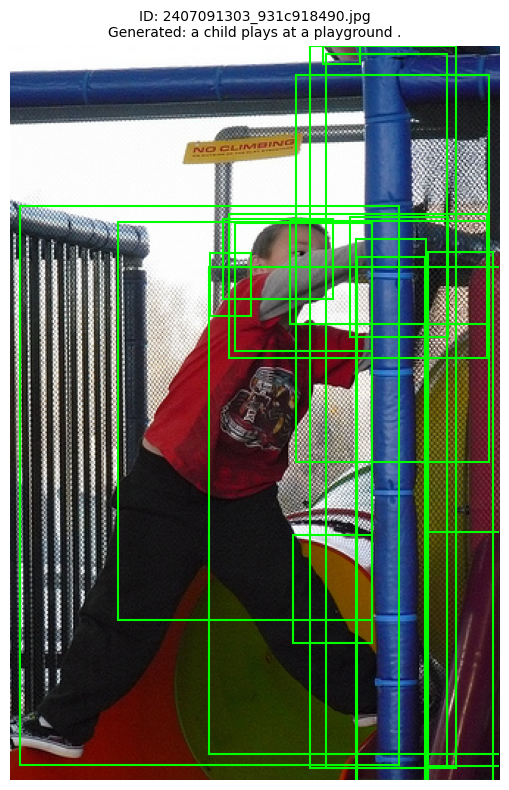

In [343]:
test_one_sample(
    model=model,
    dataset=test_dataset,
    idx2word=idx2word,
    index=898,
    feature_dir="/content/flickr8k_local/features",
    image_dir="/content/flickr8k_dataraw/Images"
)

# BLEU Score

In [262]:
!pip install git+https://github.com/salaniz/pycocoevalcap

  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-dk2u0myp
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-dk2u0myp
  Resolved https://github.com/salaniz/pycocoevalcap to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312245 sha256=b82676997e4361cf57ec7042ac38f594043030c7a27b197abcbc4e484ccd6301
  Stored in directory: /tmp/pip-ephem-wheel-cache-156iaqtu/wheels/d2/1f/44/6485e566f8ae3d42b56e7c05fd50a3bbb70a50b0e6e7c55212
Successfully built pycocoevalcap


In [271]:
def generate_caption(model, visual_feats, box_mask, semantic_idx, idx2word, max_len=25, beam_size=3):
    model.eval()
    device = visual_feats.device

    with torch.no_grad():
        v = model.blocks[0].visual_proj(visual_feats)
        v_enc = model.blocks[0].visual_encoder(v, src_key_padding_mask=box_mask)
        v_enc = model.blocks[0].visual_norm(v_enc)
        v_cond = v_enc.masked_fill(box_mask.unsqueeze(-1), 0.0).sum(dim=1) / (~box_mask).sum(dim=1, keepdim=True).clamp(min=1)

        sem_embed = model.blocks[0].semantic_embedding(semantic_idx)
        sem_proj = model.blocks[0].semantic_proj(sem_embed)
        sem_enc = model.blocks[0].semantic_encoder(sem_proj, src_key_padding_mask=(semantic_idx == 0))
        sem_enc = model.blocks[0].semantic_norm(sem_enc)
        sem_cond = sem_enc.masked_fill((semantic_idx == 0).unsqueeze(-1), 0.0).sum(dim=1) / (semantic_idx != 0).sum(dim=1, keepdim=True).clamp(min=1)

        context = v_cond + sem_cond  # [B, H]
        memory = context.unsqueeze(1)

        beams = [([1], 0.0)]  # ([token_ids], cumulative_log_prob)

        for t in range(max_len):
            new_beams = []
            for seq, score in beams:
                if seq[-1] == 2:  # <eos>
                    new_beams.append((seq, score))
                    continue

                tgt = torch.tensor(seq, dtype=torch.long, device=device).unsqueeze(0)
                tgt_embed = model.blocks[0].decoder_embedding(tgt)
                tgt_proj = model.blocks[0].decoder_input_proj(tgt_embed)

                causal_mask = torch.triu(torch.ones((tgt.size(1), tgt.size(1)), device=device), diagonal=1).bool()
                out = model.blocks[0].decoder(
                    tgt_proj, memory, tgt_mask=causal_mask, tgt_key_padding_mask=(tgt == 0))
                logits = model.blocks[0].output_proj(out)[:, -1, :]  # [1, vocab_size]
                log_probs = F.log_softmax(logits, dim=-1).squeeze(0)

                if t > 0:
                    log_probs[1] = -1e9  # ban <bos> sau bước đầu

                topk_log_probs, topk_indices = torch.topk(log_probs, beam_size)
                for i in range(beam_size):
                    new_seq = seq + [topk_indices[i].item()]
                    new_score = score + topk_log_probs[i].item()
                    new_beams.append((new_seq, new_score))

            beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_size]

            if all(seq[-1] == 2 for seq, _ in beams):
                break

        best_seq = beams[0][0][1:]  # remove <bos>
        words = []
        for idx in best_seq:
            word = idx2word.get(idx, '<unk>')
            if word == '<eos>':
                break
            if word not in ('<pad>', '<bos>'):
                words.append(word)
        return ' '.join(words)


In [272]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from pycocoevalcap.cider.cider import Cider

@torch.no_grad()
def evaluate_bleu_cider(model, test_loader, idx2word, word2idx, device="cuda", max_len=20):
    model.eval()
    smoothie = SmoothingFunction().method4

    bleu1_total = bleu2_total = bleu3_total = bleu4_total = 0
    total = 0

    # Cho CIDEr
    refs_dict = {}
    hyps_dict = {}

    for batch_id, batch in enumerate(test_loader):
        x0, visual_feats, box_mask, lengths, semantic_idx, caption_idx = batch
        x0 = x0.to(device)
        visual_feats = visual_feats.to(device)
        box_mask = box_mask.to(device)
        semantic_idx = semantic_idx.to(device)

        for i in range(x0.size(0)):
            pred_caption = generate_caption(
                model=model,
                visual_feats=visual_feats[i:i+1],
                box_mask=box_mask[i:i+1],
                semantic_idx=semantic_idx[i:i+1],
                idx2word=idx2word,
                max_len=max_len
            ).split()

            # Ground-truth reference từ caption_idx
            gt_caption = [
                idx2word.get(idx.item(), "<unk>")
                for idx in caption_idx[i]
                if idx.item() not in [
                    word2idx["<pad>"],
                    word2idx["<bos>"],
                    word2idx["<eos>"]
                ]
            ]

            # BLEU
            bleu1_total += sentence_bleu([gt_caption], pred_caption, weights=(1, 0, 0, 0), smoothing_function=smoothie)
            bleu2_total += sentence_bleu([gt_caption], pred_caption, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
            bleu3_total += sentence_bleu([gt_caption], pred_caption, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
            bleu4_total += sentence_bleu([gt_caption], pred_caption, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

            refs_dict[str(total)] = [" ".join(gt_caption)]
            hyps_dict[str(total)] = [" ".join(pred_caption)]

            total += 1

    # CIDEr
    cider = Cider()
    cider_score, _ = cider.compute_score(refs_dict, hyps_dict)

    print(f"\nEvaluation over {total} samples:")
    print(f"BLEU-1: {bleu1_total / total:.4f}")
    print(f"BLEU-2: {bleu2_total / total:.4f}")
    print(f"BLEU-3: {bleu3_total / total:.4f}")
    print(f"BLEU-4: {bleu4_total / total:.4f}")
    print(f"CIDEr : {cider_score:.4f}")

In [351]:
evaluate_bleu_cider(
    model=model,
    test_loader=test_loader,
    idx2word=idx2word,
    word2idx=word2idx,
    device="cuda"
)


Evaluation over 4050 samples:
BLEU-1: 0.2673
BLEU-2: 0.2124
BLEU-3: 0.1654
BLEU-4: 0.1182
CIDEr : 0.6243
